To do tomorrow: Create a read data function, and a test notebook where I make sure that the sum of the forces = acceleration for each body, otherwise I am trying to learn the wrong thing

In [1]:
import numpy as np
import tensorflow as tf
import graph_nets as gn
import sonnet as snt
import matplotlib.pyplot as plt
import math

Global Constants

In [2]:
# Global constants
AU = 149.6e6 * 1000 # Astronomical Unit in meters.
DAY = 24*3600. # Day in seconds
YEAR = 365.25*DAY #Year
delta_time = (2/24.)*DAY/YEAR # 1 hour
MSUN = 1.9885e+30
MEARTH = 5.9724e+24
G = 6.67428e-11/AU**3*MEARTH*YEAR**2

# Helper functions

In [3]:
# Based on the tensorflow_graphics package

def log10(x):
    #numerator = tf.log(x)
    #denominator = tf.log(tf.constant(10, dtype=numerator.dtype))
    #return numerator / denominator
    return tf.experimental.numpy.log10(x)

def cartesian_to_spherical_coordinates(point_cartesian, eps=None):
    """Function to transform Cartesian coordinates to spherical coordinates.
    This function assumes a right handed coordinate system with `z` pointing up.
    When `x` and `y` are both `0`, the function outputs `0` for `phi`. Note that
    the function is not smooth when `x = y = 0`.
    Note:
      In the following, A1 to An are optional batch dimensions.
    Args:
      point_cartesian: A tensor of shape `[A1, ..., An, 3]`. In the last
        dimension, the data follows the `x`, `y`, `z` order.
      eps: A small `float`, to be added to the denominator. If left as `None`,
        its value is automatically selected using `point_cartesian.dtype`.
      name: A name for this op. Defaults to `cartesian_to_spherical_coordinates`.
    Returns:
      A tensor of shape `[A1, ..., An, 3]`. The last dimensions contains
      (`r`,`theta`,`phi`), where `r` is the sphere radius, `theta` is the polar
      angle and `phi` is the azimuthal angle.
    """
    #with tf.compat.v1.name_scope(name, "cartesian_to_spherical_coordinates",
    #                             [point_cartesian]):
    #  point_cartesian = tf.convert_to_tensor(value=point_cartesian)

    #shape.check_static(
    #    tensor=point_cartesian,
    #    tensor_name="point_cartesian",
    #    has_dim_equals=(-1, 3))

    x, y, z = tf.unstack(point_cartesian, axis=-1)
    radius = tf.norm(tensor=point_cartesian, axis=-1)
    theta = tf.acos(
        tf.clip_by_value(tf.divide(z, radius), -1., 1.))
    phi = tf.atan2(y, x)
    return tf.stack((log10(radius), theta, phi), axis=-1)

def spherical_to_cartesian_coordinates(point_spherical, name=None):
    """Function to transform Cartesian coordinates to spherical coordinates.
    Note:
      In the following, A1 to An are optional batch dimensions.
    Args:
      point_spherical: A tensor of shape `[A1, ..., An, 3]`. The last dimension
        contains r, theta, and phi that respectively correspond to the radius,
        polar angle and azimuthal angle; r must be non-negative.
      name: A name for this op. Defaults to 'spherical_to_cartesian_coordinates'.
    Raises:
      tf.errors.InvalidArgumentError: If r, theta or phi contains out of range
      data.
    Returns:
      A tensor of shape `[A1, ..., An, 3]`, where the last dimension contains the
      cartesian coordinates in x,y,z order.
    """
    #with tf.compat.v1.name_scope(name, "spherical_to_cartesian_coordinates",
    #                           [point_spherical]):
    #point_spherical = tf.convert_to_tensor(value=point_spherical)

    #shape.check_static(
    #    tensor=point_spherical,
    #    tensor_name="point_spherical",
    #    has_dim_equals=(-1, 3))

    logr, theta, phi = tf.unstack(point_spherical, axis=-1)
    r = tf.pow(logr, 10)
    #r = asserts.assert_all_above(r, 0)
    tmp = r * tf.sin(theta)
    x = tmp * tf.cos(phi)
    y = tmp * tf.sin(phi)
    z = r * tf.cos(theta)
    return tf.stack((x, y, z), axis=-1)

In [4]:
def force_newton(x, m1, m2):
    return G*m1*m2/np.linalg.norm(x, keepdims=True)**3.*x

def reshape_senders_receivers(senders, receivers, batch_size, nplanets, nedges):
    ''' Reshape receivers and senders to use in graph'''
    x = np.arange(batch_size)
    xx = x.reshape(batch_size,1)
    y = np.ones(nedges)
    z = np.reshape(xx+y-1, batch_size*nedges)*nplanets

    senders = np.concatenate([senders]*batch_size) + z
    receivers = np.concatenate([receivers]*batch_size) + z
    
    return senders, receivers

def build_rotation_matrix(a,b,g):
    A0 = tf.stack([tf.cos(a)*tf.cos(b), tf.sin(a)*tf.cos(b), -tf.sin(b)], 
                  axis=0)
    A1 = tf.stack([tf.cos(a)*tf.sin(b)*tf.sin(g)-tf.sin(a)*tf.cos(g), 
                   tf.sin(a)*tf.sin(b)*tf.sin(g)+tf.cos(a)*tf.cos(g),
                   tf.cos(b)*tf.sin(g)], axis=0)
    A2 = tf.stack([tf.cos(a)*tf.sin(b)*tf.cos(g)+tf.sin(a)*tf.sin(g), 
                   tf.sin(a)*tf.sin(b)*tf.cos(g)-tf.cos(a)*tf.sin(g),
                   tf.cos(b)*tf.cos(g)], axis=0)
    
    return tf.stack((A0, A1, A2), axis=1)

def rotate_data(D, A):
    # I think the maxes should be 2pi, pi, pi, but going for overkill just in case
    alpha = tf.random.uniform([], minval=0, maxval=2*np.pi, dtype=tf.dtypes.float32)
    beta = tf.random.uniform([], minval=0, maxval=2*np.pi, dtype=tf.dtypes.float32)
    gamma = tf.random.uniform([], minval=0, maxval=2*np.pi, dtype=tf.dtypes.float32)
    #print(alpha) #It works! (Different every time)
    R = build_rotation_matrix(alpha,beta,gamma)
    #D = tf.einsum('ij,jk->ik', D,R)
    #A = tf.einsum('ij,jk->ik', A,R)
    D = tf.linalg.matmul(D,R)
    A = tf.linalg.matmul(A,R)
    return D, A

Training variables

In [5]:
# Training variables
batch_size_tr = 75
patience = 5
d_patience = 0
noise_level = 0.05
log_every_iterations = 1000
num_training_iterations = 200000

# Do not change this
total_time_traj = 20 #Years
num_time_steps_total = int(total_time_traj/delta_time)
num_time_steps_tr = 75000 
num_time_steps_sr = 3000 
#num_time_steps_val = int(total_time_traj/delta_time) - num_time_steps_tr

Read the data

In [76]:
masses = np.array([MSUN/MEARTH, # Sun
                   0.33011 * 10**24/MEARTH, # Mercury
                   4.8685 * 10**24/MEARTH, # Venus
                   1, # Earth
                   0.64171 * 10**24/MEARTH, #Mars
                   1898.19 * 10**24/MEARTH, # Jupiter
                   #0.08931900 * 10**24/MEARTH,
                   #0.048 * 10**24/MEARTH,
                   #0.14819 * 10**24/MEARTH,
                   #0.10759 * 10**24/MEARTH,
                   568.34 * 10**24/MEARTH, # Saturn
                   #0.001095452 * 10**24/MEARTH,
                   #0.002306518 * 10**24/MEARTH,
                   #0.1353452 * 10**24/MEARTH,
                   #0.000037493 * 10**24/MEARTH,
                   #0.001805635 * 10**24/MEARTH,
                   #0.000108022 * 10**24/MEARTH,
                   #0.000617449 * 10**24/MEARTH, 
                   1
          ])

orbit_sun = np.loadtxt('nasa_orbits/barycenter/sun.txt', usecols = [2,3,4, 5, 6, 7], unpack=True, delimiter=',')
orbit_mercury = np.loadtxt('nasa_orbits/barycenter/mercury.txt', usecols = [2,3,4, 5, 6, 7], unpack=True, delimiter=',')
orbit_venus = np.loadtxt('nasa_orbits/barycenter/venus.txt', usecols = [2,3,4, 5, 6, 7], unpack=True, delimiter=',')
orbit_earth = np.loadtxt('nasa_orbits/barycenter/earth.txt', usecols = [2,3,4, 5, 6, 7], unpack=True, delimiter=',')
orbit_moon = np.loadtxt('nasa_orbits/barycenter/moon.txt', usecols = [2,3,4, 5, 6, 7], unpack=True, delimiter=',')
orbit_mars = np.loadtxt('nasa_orbits/barycenter/mars.txt', usecols = [2,3,4, 5, 6, 7], unpack=True, delimiter=',')
orbit_deimos = np.loadtxt('nasa_orbits/barycenter/deimos.txt', usecols = [2,3,4, 5, 6, 7], unpack=True, delimiter=',')
orbit_phobos = np.loadtxt('nasa_orbits/barycenter/phobos.txt', usecols = [2,3,4, 5, 6, 7], unpack=True, delimiter=',')
orbit_jupiter = np.loadtxt('nasa_orbits/barycenter/jupiter.txt', usecols = [2,3,4, 5, 6, 7], unpack=True, delimiter=',')
orbit_io = np.loadtxt('nasa_orbits/barycenter/io.txt', usecols = [2,3,4, 5, 6, 7], unpack=True, delimiter=',')
orbit_europa = np.loadtxt('nasa_orbits/barycenter/europa.txt', usecols = [2,3,4, 5, 6, 7], unpack=True, delimiter=',')
orbit_ganymede = np.loadtxt('nasa_orbits/barycenter/ganymede.txt', usecols = [2,3,4, 5, 6, 7], unpack=True, delimiter=',')
orbit_callisto = np.loadtxt('nasa_orbits/barycenter/callisto.txt', usecols = [2,3,4, 5, 6, 7], unpack=True, delimiter=',')
orbit_saturn = np.loadtxt('nasa_orbits/barycenter/saturn.txt', usecols = [2,3,4, 5, 6, 7], unpack=True, delimiter=',')
orbit_dione = np.loadtxt('nasa_orbits/barycenter/dione.txt', usecols = [2,3,4, 5, 6, 7], unpack=True, delimiter=',')
orbit_rhea = np.loadtxt('nasa_orbits/barycenter/rhea.txt', usecols = [2,3,4, 5, 6, 7], unpack=True, delimiter=',')
orbit_titan = np.loadtxt('nasa_orbits/barycenter/titan.txt', usecols = [2,3,4, 5, 6, 7], unpack=True, delimiter=',')
orbit_mimas = np.loadtxt('nasa_orbits/barycenter/mimas.txt', usecols = [2,3,4, 5, 6, 7], unpack=True, delimiter=',')
orbit_iapetus = np.loadtxt('nasa_orbits/barycenter/iapetus.txt', usecols = [2,3,4, 5, 6, 7], unpack=True, delimiter=',')
orbit_hyperion = np.loadtxt('nasa_orbits/barycenter/hyperion.txt', usecols = [2,3,4, 5, 6, 7], unpack=True, delimiter=',')
orbit_enceladus = np.loadtxt('nasa_orbits/barycenter/enceladus.txt', usecols = [2,3,4, 5, 6, 7], unpack=True, delimiter=',')
orbit_tethys = np.loadtxt('nasa_orbits/barycenter/tethys.txt', usecols = [2,3,4, 5, 6, 7], unpack=True, delimiter=',')
orbit_neptune = np.loadtxt('nasa_orbits/barycenter/neptune.txt', usecols = [2,3,4, 5, 6, 7], unpack=True, delimiter=',')


moon_mass = 0.0734767309 * 10**24/MEARTH

deimos_mass = 1.4762 * 10**15/MEARTH
phobos_mass = 1.0659 * 10**16/MEARTH

io_mass =0.08931900 * 10**24/MEARTH
europa_mass =0.048 * 10**24/MEARTH
ganymede_mass = 0.14819 * 10**24/MEARTH
callisto_mass =0.10759 * 10**24/MEARTH

dione_mass =0.001095452 * 10**24/MEARTH
rhea_mass =0.002306518 * 10**24/MEARTH
titan_mass =0.1353452 * 10**24/MEARTH
mimas_mass =0.000037493 * 10**24/MEARTH
iapetus_mass =0.001805635 * 10**24/MEARTH
hyperion_mass = 5.6199 * 10**18/MEARTH
enceladus_mass = 0.000108022 * 10**24/MEARTH
tethys_mass = 0.000617449 * 10**24/MEARTH

'''
orbit_earth[:,:] += (orbit_moon[:,:]*moon_mass)/masses[3]

orbit_mars[:,:] += (orbit_deimos[:,:]*deimos_mass + orbit_phobos[:,:]*phobos_mass)/masses[4]

orbit_jupiter[:,:] += (orbit_io[:,:]*io_mass + orbit_europa[:,:]*europa_mass + 
                       orbit_ganymede[:,:]*ganymede_mass + orbit_callisto[:,:]*callisto_mass)/masses[5]


orbit_saturn[:,:] += (orbit_dione[:,:]*dione_mass + orbit_rhea[:,:]*rhea_mass + 
                       orbit_titan[:,:]*titan_mass + orbit_iapetus[:,:]*iapetus_mass +
                     orbit_mimas[:,:]*mimas_mass + orbit_hyperion[:,:]*hyperion_mass + 
                      orbit_enceladus[:,:]*enceladus_mass + orbit_tethys[:,:]*tethys_mass)/masses[6]
'''
nplanets = len(masses)
nedges = nplanets*(nplanets-1)//2
#masses*=1000

In [77]:
data = np.stack([orbit_sun, 
                 orbit_mercury, 
                 orbit_venus,
                 orbit_earth, 
                 orbit_mars, 
                 orbit_jupiter, 
                 #orbit_io, 
                 #orbit_europa, 
                 #orbit_ganymede,  
                 #orbit_callisto,
                 orbit_saturn, 
                 #orbit_dione, 
                 #orbit_rhea, 
                 #orbit_titan, 
                 #orbit_mimas, 
                 #orbit_iapetus, 
                 #orbit_enceladus, 
                 #orbit_tethys, 
                 orbit_neptune
                ])
data = data.transpose(2,0,1)

# Change frame of reference to the barycenter of the planets we are using
P = masses[np.newaxis, :, np.newaxis]*data[:,:,3:]
V_ref = np.sum(P, axis = 1,keepdims=True)/np.sum(masses)
#data[:,:,3:] -= V_ref

A = data[1:,:,3:] - data[:-1,:,3:]
data[:-1, :, 3:] = A 
data = data[:-1]

# Split into training and validation
data_tr = data[:num_time_steps_tr]
data_val = data[num_time_steps_tr:]

num_time_steps_val = len(data_val)

# Shuffle the data
np.random.shuffle(data_tr)
np.random.shuffle(data_val)

D_tr_np = np.empty([len(data_tr), nedges, 3])
D_val_np = np.empty([len(data_val), nedges, 3])
F_val = np.empty([len(data_val), nedges, 3])
k=0
names = ['Sun', 'Mercury', 'Venus', 'Earth', 'Mars', 'Jupiter', 'Saturn', 'Uranus', 'Neptune']
names_edges = []
senders, receivers = [], []
for i in range(nplanets):
    for j in range(nplanets):
        if i > j:
            d_tr = data_tr[:,j,:3] - data_tr[:,i,:3]
            d_val = data_val[:,j,:3] - data_val[:,i,:3]
            D_tr_np[:,k,:] = d_tr#cartesian_to_spherical_coordinates(d_tr)
            D_val_np[:,k,:] = d_val #cartesian_to_spherical_coordinates(d_val)
            F_val[:,k,:] = force_newton(d_val, masses[i], masses[j]) #cartesian_to_spherical_coordinates(d_val)
            names_edges.append(names[j] + ' - ' + names[i])
            
            k+=1 
            receivers.append(i)
            senders.append(j)

A_tr = data_tr[:,:,3:]
A_val = data_val[:,:,3:]
A_norm =np.std(A_tr) 

A_norm_dim= tf.reduce_mean(tf.norm(A_tr/A_norm, axis = -1, keepdims = False), axis = 0)
A_norm_tr = tf.convert_to_tensor([A_norm_dim]*batch_size_tr, dtype="float32")
A_norm_tr = tf.reshape(A_norm_tr, shape = [batch_size_tr*nplanets, 1])
A_norm_val = tf.convert_to_tensor([A_norm_dim]*num_time_steps_val, dtype="float32")
A_norm_val = tf.reshape(A_norm_val, shape = [num_time_steps_val*nplanets, 1])

D_tr_flat = np.reshape(D_tr_np, [num_time_steps_tr*nedges, 3])
D_val_flat = np.reshape(D_val_np,[1, num_time_steps_val*nedges, 3])

A_tr_flat = np.reshape(A_tr/A_norm, [num_time_steps_tr*nplanets, 3])
A_val_flat = np.reshape(A_val/A_norm, [1, num_time_steps_val*nplanets, 3])

D_tr = tf.convert_to_tensor(D_tr_flat, dtype="float32")
A_tr = tf.convert_to_tensor(A_tr_flat, dtype="float32")
D_tr_batches = tf.split(D_tr,  1000)
A_tr_batches = tf.split(A_tr,  1000)

D_val = tf.convert_to_tensor(D_val_flat, dtype="float32")
A_val = tf.convert_to_tensor(A_val_flat, dtype="float32")

train_ds = tf.data.Dataset.from_tensor_slices(
    (D_tr_batches, A_tr_batches))#.batch(batch_size_tr)

test_ds = tf.data.Dataset.from_tensor_slices(
    (D_val, A_val))

#D_val = tf.convert_to_tensor(D_val[:,:,:], dtype="float32")
#A_val = tf.convert_to_tensor(A_val/A_norm, dtype="float32")

#D_val_flat = tf.reshape(D_val, shape = [num_time_steps_val*nedges, 3])
#A_val_flat = tf.reshape(A_val/A_norm, shape = [num_time_steps_val*nedges, 3])

nodes_tr = np.concatenate([np.log(masses)]*batch_size_tr)[:,np.newaxis]
nodes_val = np.concatenate([np.log(masses)]*num_time_steps_val)[:,np.newaxis]
nodes_sr = np.concatenate([np.log(masses)]*num_time_steps_sr)[:,np.newaxis]

senders_tr, receivers_tr = reshape_senders_receivers(senders, receivers, batch_size_tr, nplanets, nedges)
senders_val, receivers_val = reshape_senders_receivers(senders, receivers, num_time_steps_val, nplanets, nedges)
senders_sr, receivers_sr = reshape_senders_receivers(senders, receivers, num_time_steps_sr, nplanets, nedges)

In [8]:
def mean_weighted_error(y_true, y_pred, norm):
    x = (y_pred - y_true)/norm*tf.reduce_mean(norm)

    return tf.reduce_mean(tf.reduce_sum(x**2, axis = -1))
    
class MeanWeightedError(tf.keras.metrics.Metric):
    def __init__(self, name="mean_weighted_error", **kwargs):
        super(MeanWeightedError, self).__init__(name=name, **kwargs)
        self.mwe = self.add_weight(name="mwe", initializer="zeros")

    def update_state(self, y_true, y_pred, norm):
        self.mwe.assign_add(mean_weighted_error(y_true, y_pred, norm))

    def result(self):
        return self.mwe

    def reset_states(self):
        # The state of the metric will be reset at the start of each epoch.
        self.mwe.assign(0.0)


In [9]:
#nplanets, _, ntime = X.shape
loss_tracker = tf.keras.metrics.Mean(name='loss')
#loss_test = tf.keras.metrics.MeanAbsoluteError(name='loss_test')
loss_test = MeanWeightedError(name='loss_test')

class LearnForces(tf.keras.Model):
    def __init__(self):
        super(LearnForces, self).__init__()
        self.test_loss_metric = tf.keras.metrics.MeanAbsoluteError(name='test_loss')
        self.nplanets = nplanets
        
        #m_init = tf.random_normal_initializer()
        #self.m = tf.Variable(
        #    initial_value=m_init(shape=(self.nplanets,), dtype="float32"),
        #    trainable=True,
        #)
        
        self.graph_network = gn.blocks.EdgeBlock(
            #edge_model_fn=lambda: snt.nets.MLP([32, 32, 3]),
            edge_model_fn=lambda: snt.nets.MLP([128,128,128,128, 3]),
            use_edges = True,
            use_receiver_nodes = True,
            use_sender_nodes = True,
            use_globals = False,
        )
        #self.graph_network = gn.modules.GraphNetwork(
            #edge_model_fn=lambda: snt.Linear(output_size=3),
            #node_model_fn=None,
            #global_model_fn=None,
            #edge_block_opt = {'use_edges': True, 
            #                  'use_receiver_nodes': True,
            #                  'use_sender_nodes': True,
            #                  'use_globals': False,
            #                 }
        #)

    def sum_forces(self, graph):
        b1_tr = gn.blocks.ReceivedEdgesToNodesAggregator(reducer = tf.math.unsorted_segment_sum)(graph)
        b2_tr = gn.blocks.SentEdgesToNodesAggregator(reducer = tf.math.unsorted_segment_sum)(graph)
        summed_forces = b1_tr-b2_tr
        return summed_forces
            
    def get_acceleration(self, forces, graph):
        acceleration_tr = tf.divide(forces, tf.exp(graph.nodes))
        return acceleration_tr
        #output_ops_tr = tf.reshape(acceleration_tr, shape=[self.ntime, self.nplanets, 3])
        #return output_ops_tr
        
    def call(self, g, extract = False):
        #self.ntime = len(g.nodes)//nplanets
        #g = g.replace(
        #    edges = cartesian_to_spherical_coordinates(g.edges))
        g = self.graph_network(g)
        #g = g.replace(
        #    edges = spherical_to_cartesian_coordinates(g.edges))
        f = self.sum_forces(g)
        a = self.get_acceleration(f, g)
        if extract == True: 
            f = tf.reshape(g.edges, shape=[-1, nedges, 3]).numpy()
            a = tf.reshape(a, shape=[-1, nplanets, 3]).numpy()
            return a, f
        else: 
            return a
    
    def train_step(self, data):
        #if isinstance(data, tuple):
        #    data = data[0]
        # Unpack the data
        D, A = data
        
        D_rot, A_rot = rotate_data(D, A)
        
        D_noise = tf.random.normal(tf.shape(D), 0, noise_level, tf.float32)
        D_rot = D_rot + D_noise
                                   
        # Could make a "get_senders_receivers" function, that takes
        # nplanets and returns the arrays. 
        # Will also have to make one that gets the nodes from the 
        # masses it is learning
        # That will make everything more self contained

        # Randomly 3D rotate the data
        
        graph_dict = { 
          "nodes": nodes_tr,
          "edges": D_rot, 
          "receivers": receivers_tr, 
          "senders": senders_tr 
           } 
    
        g = gn.utils_tf.data_dicts_to_graphs_tuple([graph_dict])
    
        with tf.GradientTape() as tape:
            # Forward pass
            predictions = self(g)
            # Compute the loss
            loss = mean_weighted_error(A_rot, predictions, A_norm_tr)
        
        # Compute gradients
        trainable_vars = model.graph_network.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        
        # Update weights
        self.optimizer.apply_gradients(zip(gradients,trainable_vars))

        loss_tracker.update_state(loss)
        return {"loss": loss_tracker.result()}

    def test_step(self,data):
        # Unpack the data
        D, A = data
        
        graph_dict = { 
          "nodes": nodes_val,
          "edges": D, 
          "receivers": receivers_val,
          "senders": senders_val 
           } 

        g = gn.utils_tf.data_dicts_to_graphs_tuple([graph_dict])
        
        predictions = self(g)

        #self.A_pred = tf.reshape(predictions, shape=[-1, self.nplanets, 3])
        #loss_test = tf.keras.metrics.MeanAbsoluteError(A, predictions)
        #loss_tracker.update_state(loss_test)

        #self.losses.append(tf.keras.losses.MeanAbsoluteError)
        # Updates the metrics tracking the loss
        #self.compiled_loss(A, predictions, regularization_losses=self.losses) 
    
        # Update the metrics.
        #loss_test.update_state(A, predictions)
        loss_test.update_state(A, predictions, A_norm_val)
        
        return {"loss": loss_test.result()}
    
    @property
    def metrics(self):
        # We list our `Metric` objects here so that `reset_states()` can be
        # called automatically at the start of each epoch
        # or at the start of `evaluate()`.
        # If you don't implement this property, you have to call
        # `reset_states()` yourself at the time of your choosing.
        return [loss_tracker, loss_test]



In [10]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', 
                                            verbose = 1,
                                            patience=20, 
                                            restore_best_weights=True)
model = LearnForces()

#model.compile(run_eagerly=True)
model.compile()

In [11]:
model.fit(train_ds, 
          epochs = 1000, 
          verbose=2,
          callbacks=[callback], 
          validation_data=test_ds)

Epoch 1/1000
1000/1000 - 13s - loss: 13.0198 - val_loss: 0.1973
Epoch 2/1000
1000/1000 - 6s - loss: 0.1285 - val_loss: 0.0822
Epoch 3/1000
1000/1000 - 6s - loss: 0.0871 - val_loss: 0.0730
Epoch 4/1000
1000/1000 - 5s - loss: 0.0578 - val_loss: 0.0629
Epoch 5/1000
1000/1000 - 5s - loss: 0.0423 - val_loss: 0.0355
Epoch 6/1000
1000/1000 - 5s - loss: 0.0332 - val_loss: 0.0295
Epoch 7/1000
1000/1000 - 6s - loss: 0.0288 - val_loss: 0.0123
Epoch 8/1000
1000/1000 - 6s - loss: 0.0261 - val_loss: 0.0212
Epoch 9/1000
1000/1000 - 6s - loss: 0.0244 - val_loss: 0.0153
Epoch 10/1000
1000/1000 - 6s - loss: 0.0231 - val_loss: 0.0229
Epoch 11/1000
1000/1000 - 6s - loss: 0.0220 - val_loss: 0.0216
Epoch 12/1000
1000/1000 - 6s - loss: 0.0211 - val_loss: 0.0105
Epoch 13/1000
1000/1000 - 6s - loss: 0.0205 - val_loss: 0.0136
Epoch 14/1000
1000/1000 - 6s - loss: 0.0200 - val_loss: 0.0154
Epoch 15/1000
1000/1000 - 7s - loss: 0.0194 - val_loss: 0.0066
Epoch 16/1000
1000/1000 - 8s - loss: 0.0190 - val_loss: 0.0167

Epoch 131/1000
1000/1000 - 7s - loss: 0.0147 - val_loss: 0.0043
Epoch 132/1000
1000/1000 - 7s - loss: 0.0147 - val_loss: 0.0076
Epoch 133/1000
1000/1000 - 7s - loss: 0.0148 - val_loss: 0.0054
Epoch 134/1000
1000/1000 - 7s - loss: 0.0148 - val_loss: 0.0051
Epoch 135/1000
1000/1000 - 7s - loss: 0.0148 - val_loss: 0.0048
Epoch 136/1000
1000/1000 - 7s - loss: 0.0148 - val_loss: 0.0067
Epoch 137/1000
1000/1000 - 7s - loss: 0.0148 - val_loss: 0.0066
Epoch 138/1000
1000/1000 - 7s - loss: 0.0147 - val_loss: 0.0067
Epoch 139/1000
1000/1000 - 7s - loss: 0.0148 - val_loss: 0.0076
Epoch 140/1000
1000/1000 - 7s - loss: 0.0148 - val_loss: 0.0053
Epoch 141/1000
1000/1000 - 7s - loss: 0.0148 - val_loss: 0.0060
Epoch 142/1000
1000/1000 - 7s - loss: 0.0155 - val_loss: 0.0112
Epoch 143/1000
1000/1000 - 8s - loss: 0.0150 - val_loss: 0.0041
Epoch 144/1000
1000/1000 - 8s - loss: 0.0147 - val_loss: 0.0046
Epoch 145/1000
1000/1000 - 8s - loss: 0.0147 - val_loss: 0.0053
Epoch 146/1000
1000/1000 - 7s - loss: 0.

KeyboardInterrupt: 

In [12]:
model.evaluate(test_ds)

1/1 [==============================] - 0s 420ms/step - loss: 0.0045


0.004501597955822945

# Evaluate on validation data

In [13]:
graph_dict = { 
          "nodes": nodes_val,
          "edges": D_val_flat[0], 
          "receivers": receivers_val, 
          "senders": senders_val 
           } 
    
g = gn.utils_tf.data_dicts_to_graphs_tuple([graph_dict])
ap ,fp = model(g, extract = True)


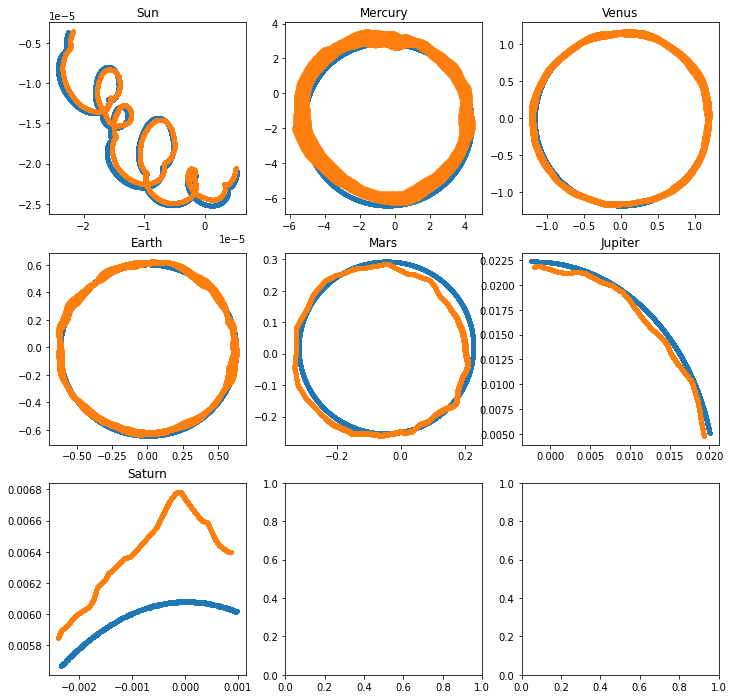

In [14]:
ncols = math.ceil(nplanets/3)
fig, ax = plt.subplots(math.ceil(nplanets/3), 3, figsize = (12, 4*ncols))
for i in range(nplanets):
    ax[i//3, i%3].set_title(names[i])
    ax[i//3, i%3].plot(data_val[:,i,3]/A_norm, data_val[:,i,4]/A_norm, '.')
    ax[i//3, i%3].plot(ap[:,i,0], ap[:,i,1], '.')



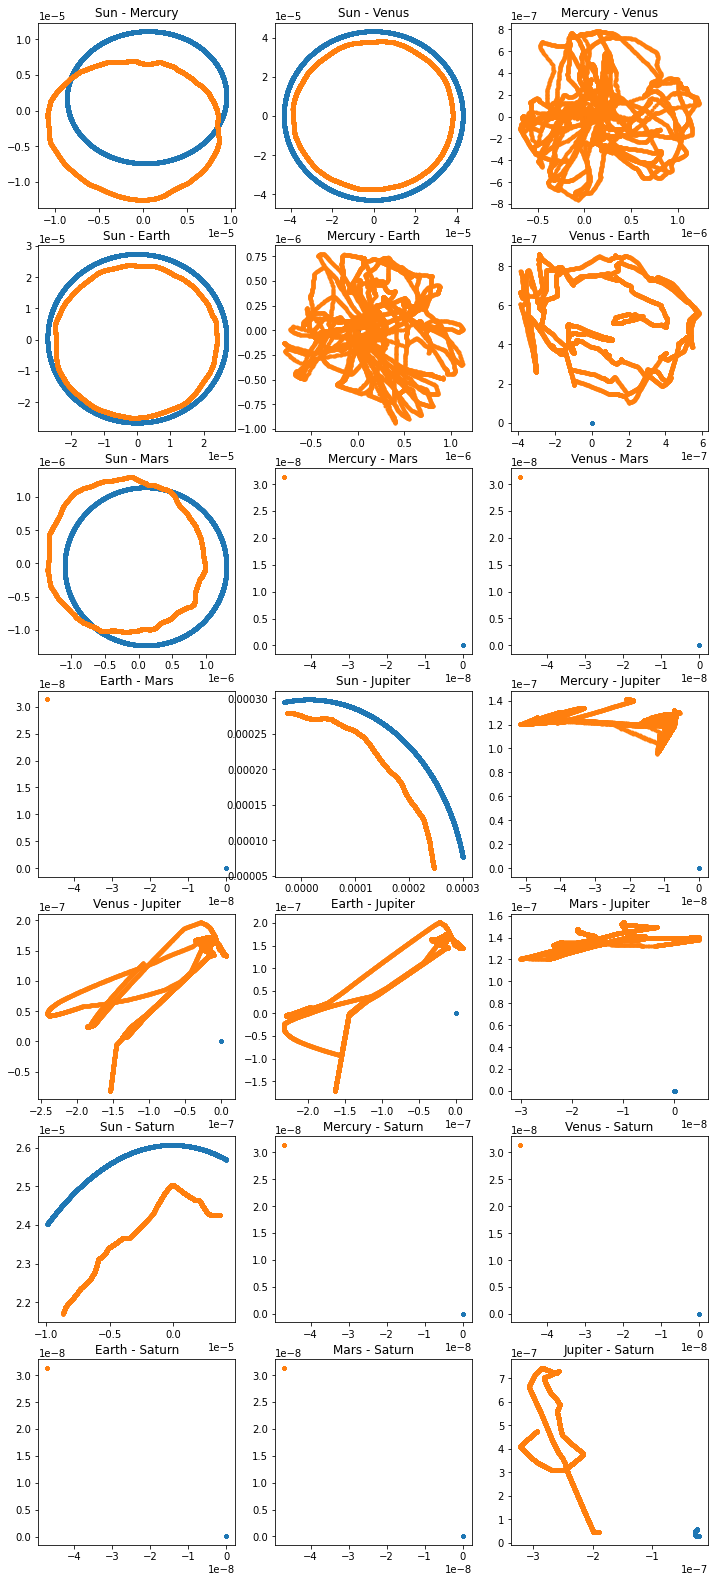

In [15]:
ncols = math.ceil(nedges/3)
fig, ax = plt.subplots(ncols, 3, figsize = (12, 4*ncols))
for i in range(nedges):
    ax[i//3, i%3].set_title(names_edges[i])
    ax[i//3, i%3].plot(F_val[:,i,0], F_val[:,i,1], '.')
    ax[i//3, i%3].plot(fp[:,i,0]*A_norm, fp[:,i,1]*A_norm, '.')

In [ ]:
ncols = math.ceil(nedges/3)
fig, ax = plt.subplots(ncols, 3, figsize = (12, 4*ncols))
for i in range(nedges):
    ax[i//3, i%3].set_title(names_edges[i])
    ax[i//3, i%3].plot(D_val_np[:,i,0], D_val_np[:,i,1], '.')
    #ax[i//3, i%3].plot(fp[:,i,0]*A_norm, fp[:,i,1]*A_norm, '.')

In [ ]:
dv = tf.reshape(D_val, [-1, nedges, 3])
dv, fp = rotate_data(dv, fp)
F_pred_sr = np.empty([num_time_steps_sr, nedges, 3])
D_val_sr = np.empty([num_time_steps_sr, nedges, 3])
for i in range(num_time_steps_sr):
    Dv_temp, Fp_temp = rotate_data(dv[i], fp[i])
    F_pred_sr[i] = Fp_temp
    D_val_sr[i] = Dv_temp


In [ ]:
'''
indices = [0,1,3,6,10,15,21]
X = np.zeros([(nplanets-1)*num_time_steps_sr,5])
F = np.zeros([(nplanets-1)*num_time_steps_sr,3])
F_norm = np.mean(F_pred_sr)
k=0
for i in range(nplanets):
    for j in range(nplanets):
        if ((i>j) and (j==0)):
            print(i,j,k, indices[i])
            X[k*num_time_steps_sr:(k+1)*num_time_steps_sr,0] = masses[i]
           #X[k*num_time_steps_sr:(k+1)*num_time_steps_sr,1] = masses[j]
            X[k*num_time_steps_sr:(k+1)*num_time_steps_sr,1:4] = D_val_sr[:,indices[k],:]
            X[k*num_time_steps_sr:(k+1)*num_time_steps_sr,4] = np.linalg.norm(D_val_sr[:,indices[k],:], axis = -1)#**3
            F[k*num_time_steps_sr:(k+1)*num_time_steps_sr,:] = F_pred_sr[:,indices[k],:]#/F_norm #works better with
            k+=1
'''

In [ ]:
X = np.zeros([nedges*num_time_steps_sr,6])
F = np.zeros([nedges*num_time_steps_sr,3])
F_norm = np.mean(F_pred_sr)
k=0
for i in range(nplanets):
    for j in range(nplanets):
        if i>j:
            X[k*num_time_steps_sr:(k+1)*num_time_steps_sr,0] = masses[i]
            X[k*num_time_steps_sr:(k+1)*num_time_steps_sr,1] = masses[j]
            X[k*num_time_steps_sr:(k+1)*num_time_steps_sr,2:5] = D_val_sr[:,k,:]
            X[k*num_time_steps_sr:(k+1)*num_time_steps_sr,5] = np.linalg.norm(D_val_sr[:,k,:], axis = -1)#**3
            F[k*num_time_steps_sr:(k+1)*num_time_steps_sr,:] = F_pred_sr[:,k,:]/F_norm #works better with
            k+=1


In [ ]:
D_val_sr.shape

In [ ]:
from pysr import pysr
# Learn equations
equations = []
for i in range(1):
    equation = pysr(X[:,:], F[:,i]/np.std(F[:,i]), niterations=50,
            #maxsize = 100,
            populations = 16,
            #variable_names = ['m0', 'm1', 'x', 'y', 'z', 'r'],
            binary_operators=["mult", "div"],
            unary_operators=["square", "cube"])
    equations.append(equation)

In [ ]:
plt.plot(169.11046*X[:,1]*X[:,4], '.')

In [ ]:
#plt.plot(1.32073279045523e-5*X[:,1]*X[:,2], '.')
n = 0000
m = 20000
plt.plot((F[n:m,0])/np.std(F[:,0]), '.')
plt.plot(2e-6*X[n:m,2]*X[n:m,1]*X[n:m,0]/X[n:m,5]**3, '.')

In [ ]:
plt.plot(2e-6*X[:,2]*X[:,1]*X[:,0]/X[:,5]**3, '.')

In [ ]:
equations[0]

In [ ]:
plt.plot(F[:,0])
plt.plot(23926.0485779911*X[:,0]*X[:,1]**2)
plt.plot(2e9*G*X[:,0]*X[:,1]*X[:,2]/X[:,5]**2.)

In [ ]:
plt.plot(G*X[:,0]*X[:,1]*X[:,2]/X[:,5]**2.*2e9)

# TO DO:

### To finish the project
- Include moons
- Learn masses
- Use barycenter data directly

### To clean the model
- Clean mean_weighted_error implementation
- Include loss_test in fit 
- Use it for early stopping? 
- Make the model calculate the senders and receivers from input shape
- Include creating the graph in the model call, so the model takes an array of distances, not a graph? (Check if this makes things slower). See https://www.tensorflow.org/guide/keras/functional
- Make a separate script that creates the data
- Include some kind of training progress bar
- Improve plotting

# For next meeting
- So far, with the moons, even with the true masses given, the MLP struggles with learning. It gets stuck sending all edges involving the moons to zero. Suggestions?
- When I try to do symbolic regression with all edges (not just those involving the sun) PySR often struggles to find the correct formula, instead it gets stuck in things like m1*x or m0*x/r, even though when it does find the correct formula, it has a massively smaller MSE. Are there any settings I can give PySR to help it? It does work if I give it $r^3$ as a parameter, but that feels like cheating
- It keeps learning Saturn wrong, but I have no idea why

# Requirements
- The graphnets tensorflow 2 installation
- pysr

In [ ]:
i=1
plt.plot(fp[:,i,0]*A_norm, fp[:,i,1]*A_norm, '.')
plt.plot(-F_val[:,i,0], -F_val[:,i,1], '.')

In [ ]:
plt.plot(-F_val[:,i,0]*delta_time, -F_val[:,i,1]*delta_time, '.')

In [ ]:
delta_time

In [ ]:
D_val_np.shape

In [ ]:
D_val_flat.shape

In [ ]:
plt.plot(data[:100,1,0] + data[:100,1,1], '.')

In [ ]:
data.shape

In [ ]:
orbit_mercury.shape

In [ ]:
plt.plot(orbit_mercury[0,:], orbit_mercury[1,:])

In [ ]:
data = np.stack([orbit_sun, 
                 orbit_mercury, 
                 orbit_venus,
                 orbit_earth, 
                 orbit_mars, 
                 orbit_jupiter, 
                 orbit_io, 
                 orbit_europa, 
                 orbit_ganymede,  
                 orbit_callisto,
                 orbit_saturn, 
                 orbit_dione, 
                 orbit_rhea, 
                 orbit_titan, 
                 orbit_mimas, 
                 orbit_iapetus, 
                 orbit_enceladus, 
                 orbit_tethys, 
                ])
data = data.transpose(2,0,1)

# Change frame of reference to the barycenter of the planets we are using
P = masses[np.newaxis, :, np.newaxis]*data[:,:,3:]
V_ref = np.sum(P, axis = 1,keepdims=True)/np.sum(masses)
data[:,:,3:] -= V_ref

A = data[1:,:,3:] - data[:-1,:,3:]
data[:-1, :, 3:] = A 
data = data[:-1]
'''

# Split into training and validation
data_tr = data[:num_time_steps_tr]
data_val = data[num_time_steps_tr:]

num_time_steps_val = len(data_val)

# Shuffle the data
np.random.shuffle(data_tr)
np.random.shuffle(data_val)
'''

In [ ]:
plt.plot(data[:100,1,0], data[:100,1,1], '.')

In [ ]:
plt.plot(data[:100,3,3], data[:100,3,4], '.')

In [ ]:
LearnForces()

In [ ]:
A = tf.ones([10,2,3])
B = tf.ones([3,3])

In [ ]:
tf.tensordot(A,B, axes=1)

# Evaluate on rotated validation data

In [ ]:
D_val_sr = np.empty([nedges*num_time_steps_sr, 3])
A_val_sr = np.empty([nedges*num_time_steps_sr, 3])
for i in range(num_time_steps_sr):
    imin, imax = i*nedges, (i+1)*nedges
    D_temp, A_temp = rotate_data(D_val_flat[0,imin:imax], A_val_flat[0,imin:imax])
    #D_temp, A_temp = D_val_flat[0,imin:imax], A_val_flat[0,imin:imax]
    D_val_sr[imin:imax] = D_temp
    A_val_sr[imin:imax] = A_temp
    

graph_dict = { 
          "nodes": nodes_sr,
          "edges": D_val_sr, 
          "receivers": receivers_sr, 
          "senders": senders_sr 
           } 
    
g = gn.utils_tf.data_dicts_to_graphs_tuple([graph_dict])
ap ,fp = model(g, extract = True)


In [ ]:
D_val_sr = tf.reshape(D_val_sr, [-1, nedges, 3])
A_val_sr = tf.reshape(A_val_sr, [-1, nplanets, 3])

fig, ax = plt.subplots(math.ceil(nplanets/3), 3)
for i in range(nplanets):
    #ax[i//3, i%3].plot(data_val[:,i,3]/A_norm, data_val[:,i,4]/A_norm, '.')
    ax[i//3, i%3].plot(A_val_sr[:3,i,0], A_val_sr[:3,i,1], '.')
    ax[i//3, i%3].plot(ap[:3,i,0], ap[:3,i,1], '.')
    



In [ ]:
'''
indices = [0,1,3,6,10,15]
nforce = len(fp)
X = np.zeros([(nplanets-1)*nforce,5])
F = np.zeros([(nplanets-1)*nforce,3])
F_norm = np.mean(fp)
for i in range(nplanets-1):
    #print( X[i*nforce:(i+1)*nforce].shape, positions[:,i+1,:].shape)
    X[i*nforce:(i+1)*nforce,0] = masses[i+1]
    X[i*nforce:(i+1)*nforce,1:4] = D_val[:,indices[i],:]
    X[i*nforce:(i+1)*nforce,4] = np.linalg.norm(D_val[:,indices[i],:], axis = -1)#**3
    #F[i*nforce:(i+1)*nforce,:] = forces_true[i,:,:]#/F_norm
    F[i*nforce:(i+1)*nforce,:] = fp[:,indices[i],:]/F_norm
'''

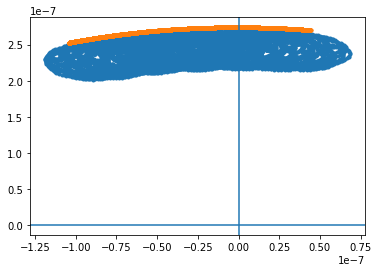

In [78]:
indices = [0,1,3,6,10,15]
i=6
plt.plot(data_val[:,i,3], data_val[:,i,4], '.')
#plt.plot(F_val[:,indices[i-1],0]/masses[i], F_val[:,indices[i-1],1]/masses[i], '.')
plt.plot((F_val[:,15,0] + F_val[:,-1,0])/masses[i], (F_val[:,15,1] + F_val[:,-1,1])/masses[i], '.')
#plt.plot(np.sum(F_val[:,15:,0], axis=1)/masses[i], np.sum(F_val[:,15:,1], axis=1)/masses[i], '.')
plt.axvline(0)
plt.axhline(0)

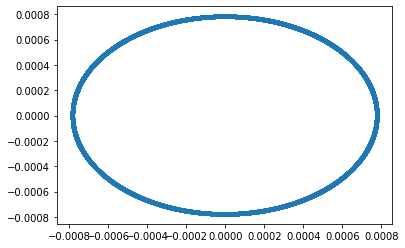

In [18]:
plt.plot(F_val[:,1,0]/masses[1], F_val[:,1,1]/masses[1], '.')

In [26]:
np.linalg.norm(F_val[:,3,:], axis=-1)/masses[2]/np.linalg.norm(data_val[:,2,3:], axis=-1)

array([0.70326717, 0.71599443, 0.70075498, ..., 0.71612549, 0.69091982,
       0.69536721])

In [27]:
delta_time

0.00022815423226100844

In [47]:
V_ref

array([[[ 5.39651417e-06, -7.41846168e-06, -9.73323233e-08]],

       [[ 5.39734243e-06, -7.41783146e-06, -9.73552699e-08]],

       [[ 5.39817061e-06, -7.41720114e-06, -9.73782151e-08]],

       ...,

       [[-8.39501771e-06, -2.02702453e-06,  2.31012970e-07]],

       [[-8.39489464e-06, -2.02794702e-06,  2.31014434e-07]],

       [[-8.39477147e-06, -2.02886950e-06,  2.31015896e-07]]])

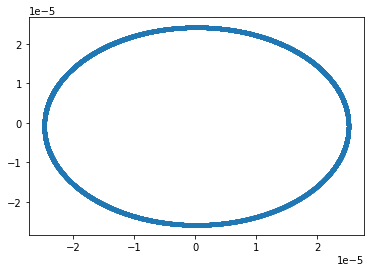

In [54]:
plt.plot(data_val[:,3,3], data_val[:,3,4], '.')